## TOC:
* [Read data](#Read-data)
* [Compute basic fitting statistics](#Compute-basic-fitting-statistics)
* [Effect of parametrization](#Effect-of-parametrization)
* [Evaluate hyperprior performance and degrees of freedom](#Evaluate-hyperprior-performance-and-degrees-of-freedom)

In [1]:
%matplotlib inline
import pandas as pd
import seaborn as sns
import numpy as np
from scipy.stats import pearsonr
sns.set_context('paper')
sns.set_style("white")
sns.set_style('ticks')
#sns.plt.style.use(['seaborn-ticks', 'seaborn-paper'])
sns.plt.rcParams['text.usetex'] = True
sns.plt.rcParams['text.latex.preamble'] = [r'\usepackage{lmodern}']
figure_width=6
boxplot_kwargs={'fliersize':4}

### Read data

In [2]:
# raw results
comparison = pd.read_pickle('../results_horseshoe_p0set/performance_comparison.pck')
comparison.rename(columns={'Parametrization':'Parameterization'}, inplace=True)
comparison.replace(to_replace='noncentered', value='non-centered', inplace=True)
comparison['Hyperprior'] = comparison['Hyperprior'].str.capitalize()
dataset_parameters = comparison.columns[:4].tolist()
model_parameters = comparison.columns[4:9].tolist()


# sampler statistics
sampler_stats = pd.read_pickle('../results_horseshoe_p0set/sampler_statistics.pck')
sampler_stats.rename(columns={'diverging': '#diverging samples'}, inplace=True)
sampler_stats.rename(columns={'Parametrization':'Parameterization'}, inplace=True)
sampler_stats.replace(to_replace='noncentered', value='non-centered', inplace=True)
sampler_stats['Hyperprior'] = sampler_stats['Hyperprior'].str.capitalize()

### Compute basic fitting statistics

In [3]:
fitting_statistics = comparison.groupby(dataset_parameters + model_parameters + ['Variable'], as_index=False).apply(
    lambda data: pd.Series({'MSE': np.mean(np.power(data['Groundtruth'] - data['Prediction (mean)'], 2))})).reset_index()

## Effect of parametrization

/Users/maexlich/.miniconda/envs/bayesian_microbiome/lib/python3.6/site-packages/ipykernel_launcher.py:2: SettingWithCopyWarning: 
A value is trying to be set on a copy of a slice from a DataFrame.
Try using .loc[row_indexer,col_indexer] = value instead

See the caveats in the documentation: http://pandas.pydata.org/pandas-docs/stable/indexing.html#indexing-view-versus-copy
  
/Users/maexlich/.miniconda/envs/bayesian_microbiome/lib/python3.6/site-packages/ipykernel_launcher.py:3: SettingWithCopyWarning: 
A value is trying to be set on a copy of a slice from a DataFrame.
Try using .loc[row_indexer,col_indexer] = value instead

See the caveats in the documentation: http://pandas.pydata.org/pandas-docs/stable/indexing.html#indexing-view-versus-copy
  This is separate from the ipykernel package so we can avoid doing imports until
/Users/maexlich/.miniconda/envs/bayesian_microbiome/lib/python3.6/site-packages/ipykernel_launcher.py:6: SettingWithCopyWarning: 
A value is trying to be set on a 

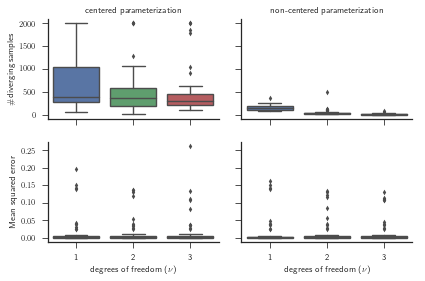

In [4]:
horseshoe_only = sampler_stats[sampler_stats.Type == 'horseshoe']
horseshoe_only['Nu'] = horseshoe_only['Nu'].astype(int)
horseshoe_only['#diverging samples'] = horseshoe_only['#diverging samples'].astype(int)

horseshoe_only_fitts = fitting_statistics[np.logical_and(fitting_statistics.Type == 'horseshoe', fitting_statistics.Variable == 'beta')]
horseshoe_only_fitts['Nu'] = horseshoe_only_fitts['Nu'].astype(int)

combined = pd.merge(horseshoe_only ,horseshoe_only_fitts, on=model_parameters + dataset_parameters)
melt_df = combined.melt(id_vars=model_parameters+dataset_parameters, value_vars=['#diverging samples', 'MSE'])
melt_df.head()
g = sns.FacetGrid(data=melt_df, col='Parameterization', col_order=['centered', 'non-centered'],row='variable', sharey='row', size=2, aspect=1.5)
g.map(sns.boxplot, 'Nu', 'value', palette=sns.color_palette()[:3], **boxplot_kwargs).set_titles('{col_name} parameterization')
g.set(xlabel="degrees of freedom ($\\nu$)")
g.axes[0,0].set_xlabel('')
g.axes[0,1].set_xlabel('')
g.axes[1,0].set_title('')
g.axes[1,1].set_title('')
g.axes[0,0].set_ylabel('\#diverging samples')
g.axes[1,0].set_ylabel('Mean squared error')
sns.plt.tight_layout()
sns.plt.savefig('/Users/maexlich/Google Drive/Studium/Master/4. Masterthesis/3. Thesis/Figures/Results/Hyperparameter-selection/parametrization-comparison.pdf')

## Evaluate hyperprior performance and degrees of freedom

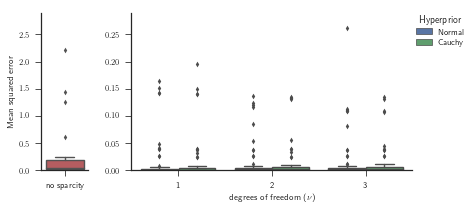

In [5]:
beta_statistics = fitting_statistics[fitting_statistics.Variable == 'beta'].copy()
beta_statistics.replace('complete', 'no sparcity', inplace=True)
beta_horseshoe_only = beta_statistics[beta_statistics.Type == 'horseshoe']

fig, axs = sns.plt.subplots(ncols=2, gridspec_kw = {'width_ratios':[1, 6]}, figsize=(6, 3))

sns.boxplot(x='Type', y='MSE', data=beta_statistics, order=['no sparcity'], ax=axs[0], color=sns.color_palette()[2], **boxplot_kwargs)
axs[0].set_ylim((0, 2.9))
axs[0].set_xlabel('')
axs[0].set_ylabel('Mean squared error')

sns.boxplot(data=beta_horseshoe_only, x='Nu', y='MSE', hue='Hyperprior', hue_order=['Normal', 'Cauchy'], ax=axs[1], **boxplot_kwargs)
axs[1].set_ylim((0, 0.29))
axs[1].set_ylabel('')
axs[1].set_xlabel("degrees of freedom ($\\nu$)")
axs[1].legend_.remove()
sns.despine()
fig.tight_layout()

handles, labels = axs[1].get_legend_handles_labels()

# When creating the legend, only use the first two elements
# to effectively remove the last two.
l = sns.plt.legend(handles, labels, bbox_to_anchor=(1.0, 1), loc=2, borderaxespad=0, title='Hyperprior')

fig.savefig('/Users/maexlich/Google Drive/Studium/Master/4. Masterthesis/3. Thesis/Figures/Results/Hyperparameter-selection/complete-normal-cauchy.pdf', bbox_extra_artists=(l,), bbox_inches='tight')

### Alpha statistics

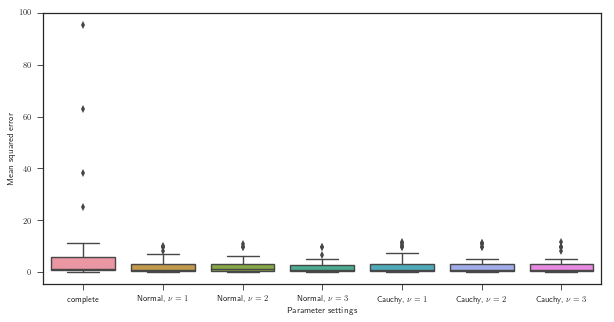

In [6]:
alpha_statistics = fitting_statistics[fitting_statistics.Variable == 'alpha'].copy()
def get_hyperprior_nu_label(row):
    return row['Type'] if row['Type'] == 'complete' else '{}, $\\nu = {}$'.format(row['Hyperprior'], row['Nu'])
alpha_statistics['Parameter settings'] = alpha_statistics.apply(get_hyperprior_nu_label, axis=1)


sns.plt.figure(figsize=(10, 5))
ax = sns.boxplot(data=alpha_statistics, x='Parameter settings', y='MSE', order=['complete', 'Normal, $\\nu = 1$',
                                                                         'Normal, $\\nu = 2$', 'Normal, $\\nu = 3$',
                                                                         'Cauchy, $\\nu = 1$', 'Cauchy, $\\nu = 2$',
                                                                         'Cauchy, $\\nu = 3$'], )
ax.set_ylabel('Mean squared error')

### Tau vs nu

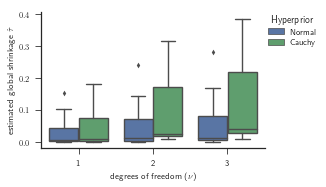

In [7]:
tau_values = comparison[(comparison.Type == 'horseshoe') & (comparison.Variable == 'tau') & (comparison.Parameterization == 'non-centered')]
sns.plt.figure(figsize=(figure_width/1.5, 2.5))
ax = sns.boxplot(data=tau_values, x='Nu', y='Prediction (mean)', hue='Hyperprior', **boxplot_kwargs)
ax.legend_.remove()
sns.despine()
ax.set_xlabel("degrees of freedom ($\\nu$)")
ax.set_ylabel('estimated global shrinkage $\\hat{\\tau}$')

handles, labels = axs[1].get_legend_handles_labels()

# When creating the legend, only use the first two elements
# to effectively remove the last two.
l = sns.plt.legend(handles, labels, bbox_to_anchor=(1.0, 1), loc=2, borderaxespad=0, title='Hyperprior')

sns.plt.savefig('/Users/maexlich/Google Drive/Studium/Master/4. Masterthesis/3. Thesis/Figures/Results/Hyperparameter-selection/nu-vs-tau.pdf', bbox_extra_artists=(l,), bbox_inches='tight')

In [8]:
def get_hyperprior_nu_label(row):
    return row['Type'] if row['Type'] == 'no sparcity' else '{}, $\\nu = {}$'.format(row['Hyperprior'], row['Nu'])

def get_dataset_without_samples(row):
    return 'nOTUs = {}, nCovariates = {}'.format(row['OTUs'], row['Covariates'])

#beta_statistics['Model'] = beta_statistics.apply(get_hyperprior_nu_label, axis=1)
beta_statistics['Dataset'] = beta_statistics.apply(get_dataset_without_samples, axis=1)

In [9]:
def compute_confusion_matrix(data):
    predicted = data['Prediction (mean)'].astype(bool)
    gt = data['Groundtruth'].astype(bool)
    TP = np.sum(predicted & gt)
    TN = np.sum((~predicted) & (~gt))
    FP = np.sum(predicted & (~gt))
    FN = np.sum((~predicted) & gt)
    N = TP + TN + FP + FN
    return pd.Series({'TP':TP, 'TN':TN, 'FP':FP, 'FN':FN, 'N':N})

In [10]:
include_covariate = comparison[comparison.Variable == 'include_covariate']
confusion_parameters = include_covariate.groupby(dataset_parameters+model_parameters).apply(compute_confusion_matrix).reset_index()
p = confusion_parameters
confusion_parameters['MCC'] = (p.TP*p.TN - p.FN*p.FP)/np.sqrt((p.TP + p.FP)*(p.TP + p.FN)*(p.TN + p.FP)*(p.TN + p.FN))

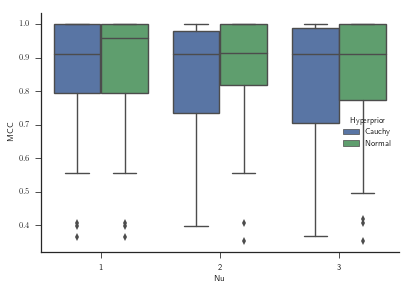

In [11]:
only_noncentered = confusion_parameters[confusion_parameters.Parameterization == 'non-centered']
sns.boxplot(data=only_noncentered, x='Nu', hue='Hyperprior', y='MCC')
sns.despine()

In [40]:
confusion_parameters[confusion_parameters['MCC'] == 1.0].shape

(103, 15)

### Potential replacement for plot above, shows performance better than MSE

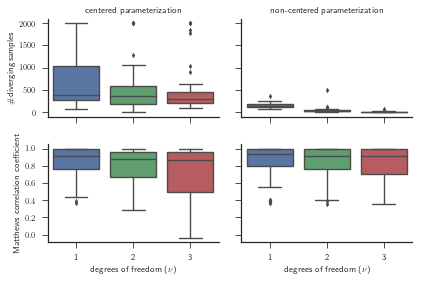

In [12]:
combined = pd.merge(horseshoe_only , confusion_parameters, on=model_parameters + dataset_parameters)
melt_df = combined.melt(id_vars=model_parameters+dataset_parameters, value_vars=['#diverging samples', 'MCC'])
melt_df.head()
g = sns.FacetGrid(data=melt_df, col='Parameterization', col_order=['centered', 'non-centered'],row='variable', sharey='row', size=2, aspect=1.5)
g.map(sns.boxplot, 'Nu', 'value', palette=sns.color_palette()[:3], **boxplot_kwargs).set_titles('{col_name} parameterization')
g.set(xlabel="degrees of freedom ($\\nu$)")
g.axes[0,0].set_xlabel('')
g.axes[0,1].set_xlabel('')
g.axes[1,0].set_title('')
g.axes[1,1].set_title('')
g.axes[0,0].set_ylabel('\#diverging samples')
g.axes[1,0].set_ylabel('Matthews correlation coefficient')
sns.plt.tight_layout()
sns.plt.savefig('/Users/maexlich/Google Drive/Studium/Master/4. Masterthesis/3. Thesis/Figures/Results/Hyperparameter-selection/parametrization-comparison-diverging-MCC.pdf')

### Signal to noise, distribution of shrinkage value

/Users/maexlich/.miniconda/envs/bayesian_microbiome/lib/python3.6/site-packages/ipykernel_launcher.py:2: SettingWithCopyWarning: 
A value is trying to be set on a copy of a slice from a DataFrame.
Try using .loc[row_indexer,col_indexer] = value instead

See the caveats in the documentation: http://pandas.pydata.org/pandas-docs/stable/indexing.html#indexing-view-versus-copy
  


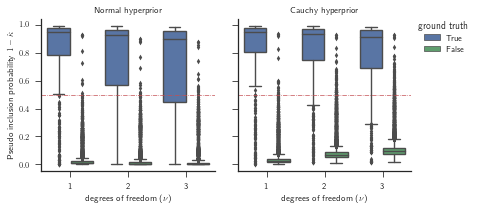

In [13]:
pip_values = comparison[(comparison.Variable == 'pip') & (comparison.Parameterization == 'non-centered')]
pip_values['GT True'] = pip_values['Groundtruth'] != 0
g = sns.FacetGrid(data=pip_values, col='Hyperprior', legend_out=True, sharey=True)
g.map(sns.boxplot, 'Nu', 'Prediction (std)', 'GT True', palette=sns.color_palette()[:2], hue_order=[True, False], **boxplot_kwargs).set_titles('{col_name} hyperprior')
g.set(xlabel="degrees of freedom ($\\nu$)")
g.axes[0,0].set(ylabel='Pseudo inclusion probability $1-\\hat{\\kappa}$')
g.axes[0,0].axhline(0.5, ls='-.', c=sns.color_palette()[2], lw=0.7)
g.axes[0,1].axhline(0.5, ls='-.', c=sns.color_palette()[2], lw=0.7)
handles, labels = g.axes[0,0].get_legend_handles_labels()

# When creating the legend, only use the first two elements
# to effectively remove the last two.
l = sns.plt.legend(handles[0:2], labels[0:2], bbox_to_anchor=(1.02, 1), loc=2, borderaxespad=0, title='ground truth')
#sns.plt.tight_layout()
sns.plt.savefig('/Users/maexlich/Google Drive/Studium/Master/4. Masterthesis/3. Thesis/Figures/Results/Hyperparameter-selection/SNR-hyperprior-nu.pdf', bbox_extra_artists=(l,), bbox_inches='tight')

/Users/maexlich/.miniconda/envs/bayesian_microbiome/lib/python3.6/site-packages/ipykernel_launcher.py:2: SettingWithCopyWarning: 
A value is trying to be set on a copy of a slice from a DataFrame.
Try using .loc[row_indexer,col_indexer] = value instead

See the caveats in the documentation: http://pandas.pydata.org/pandas-docs/stable/indexing.html#indexing-view-versus-copy
  


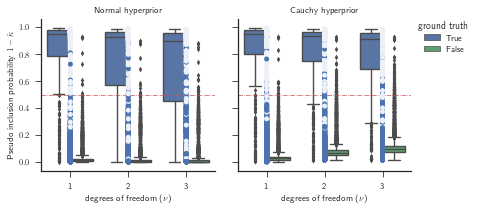

In [14]:
pip_values = comparison[(comparison.Variable == 'pip') & (comparison.Parameterization == 'non-centered')]
pip_values['GT True'] = pip_values['Groundtruth'] != 0
g = sns.FacetGrid(data=pip_values, col='Hyperprior', legend_out=True, sharey=True)
g.map(sns.boxplot, 'Nu', 'Prediction (std)', 'GT True', palette=sns.color_palette()[:2], hue_order=[True, False], **boxplot_kwargs).set_titles('{col_name} hyperprior')
#g.map(sns.stripplot, 'Nu', 'Prediction (std)', 'GT True', hue_order=[True, False]).set_titles('{col_name} hyperprior')
g.set(xlabel="degrees of freedom ($\\nu$)")
g.axes[0,0].set(ylabel='Pseudo inclusion probability $1-\\hat{\\kappa}$')
g.axes[0,0].axhline(0.5, ls='-.', c=sns.color_palette()[2], lw=0.7)
g.axes[0,1].axhline(0.5, ls='-.', c=sns.color_palette()[2], lw=0.7)
handles, labels = g.axes[0,0].get_legend_handles_labels()

# When creating the legend, only use the first two elements
# to effectively remove the last two.
l = sns.plt.legend(handles[0:2], labels[0:2], bbox_to_anchor=(1.02, 1), loc=2, borderaxespad=0, title='ground truth')
#sns.plt.tight_layout()
#sns.plt.savefig('/Users/maexlich/Google Drive/Studium/Master/4. Masterthesis/3. Thesis/Figures/Results/Hyperparameter-selection/SNR-hyperprior-nu.pdf', bbox_extra_artists=(l,), bbox_inches='tight')

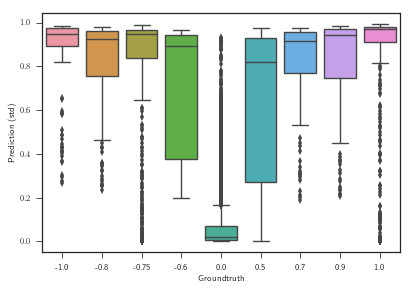

In [32]:
sns.boxplot(data=pip_values, x='Groundtruth', y='Prediction (std)')

/Users/maexlich/.miniconda/envs/bayesian_microbiome/lib/python3.6/site-packages/ipykernel_launcher.py:2: SettingWithCopyWarning: 
A value is trying to be set on a copy of a slice from a DataFrame.
Try using .loc[row_indexer,col_indexer] = value instead

See the caveats in the documentation: http://pandas.pydata.org/pandas-docs/stable/indexing.html#indexing-view-versus-copy
  


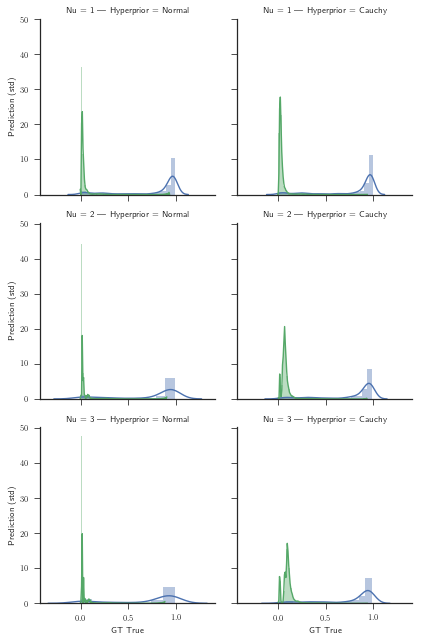

In [30]:
pip_values = comparison[(comparison.Variable == 'pip') & (comparison.Parameterization == 'non-centered')]
pip_values['GT True'] = pip_values['Groundtruth'] != 0
g = sns.FacetGrid(data=pip_values, col='Hyperprior', row='Nu', legend_out=True, sharey=True)
def two_distplots(selector, value, **kwargs):
    sns.distplot(value[selector])
    sns.distplot(value[~selector])
g.map(two_distplots, 'GT True', 'Prediction (std)')

In [15]:
def compute_confusion_matrix(data):
    predicted = data['Prediction (std)'] > 0.5
    gt = data['GT True'].astype(bool)
    TP = np.sum(predicted & gt)
    TN = np.sum((~predicted) & (~gt))
    FP = np.sum(predicted & (~gt))
    FN = np.sum((~predicted) & gt)
    N = TP + TN + FP + FN
    return pd.Series({'TP':TP, 'TN':TN, 'FP':FP, 'FN':FN, 'N':N})

pip_values.groupby(['Hyperprior', 'Nu']).apply(compute_confusion_matrix)

FN  FP      N     TN   TP
Hyperprior Nu                            
Cauchy     1    75  19  24525  24092  339
           2    76  61  24525  24050  338
           3    85  91  24525  24020  329
Normal     1    77  10  24525  24101  337
           2    99  12  24525  24099  315
           3   107  18  24525  24093  307

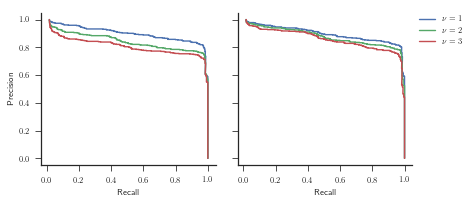

In [16]:
from sklearn.metrics import precision_recall_curve, average_precision_score
def compute_pr_curve(data):
    predicted = data['Prediction (std)']
    gt = data['GT True']
    average_precision = average_precision_score(gt, predicted)
    recall, precision, _ = precision_recall_curve(gt, predicted)
    return pd.Series({'Recall':recall, 'Precision':precision, 'average precision': average_precision})

pr_scores = pip_values.groupby(['Hyperprior', 'Nu']).apply(compute_pr_curve).reset_index()
#print(pr_scores)
g = sns.FacetGrid(data=pr_scores, col='Hyperprior', hue='Nu', col_order=['Normal', 'Cauchy'])
def draw_test(x, y, *args, **kwargs):
    sns.plt.plot(x.values[0], y.values[0], **kwargs)
g.map(draw_test, 'Recall', 'Precision').set_titles('')

handles, labels = g.axes[0,0].get_legend_handles_labels()
labels = ['$\\nu = {}$'.format(nu) for nu in labels]
l = sns.plt.legend(handles, labels, bbox_to_anchor=(1.02, 1), loc=2, borderaxespad=0)
#sns.plt.tight_layout()
sns.plt.savefig('/Users/maexlich/Google Drive/Studium/Master/4. Masterthesis/3. Thesis/Figures/Results/Hyperparameter-selection/PR-hyperprior-nu.pdf', bbox_extra_artists=(l,), bbox_inches='tight')

In [17]:
from sklearn.metrics import precision_recall_curve, average_precision_score
def compute_pr_curve(data):
    predicted = data['Prediction (std)']
    gt = data['GT True']
    average_precision = average_precision_score(gt, predicted)
    recall, precision, _ = precision_recall_curve(gt, predicted)
    return pd.Series({'Recall':recall, 'Precision':precision, 'average precision': average_precision})


pip_values['Dataset'] = pip_values.apply(lambda d: '-'.join([str(d[c]) for c in dataset_parameters]), axis=1)
pr_scores = pip_values.groupby(['Dataset']+model_parameters).apply(compute_pr_curve).reset_index()


#print(pr_scores)


/Users/maexlich/.miniconda/envs/bayesian_microbiome/lib/python3.6/site-packages/ipykernel_launcher.py:10: SettingWithCopyWarning: 
A value is trying to be set on a copy of a slice from a DataFrame.
Try using .loc[row_indexer,col_indexer] = value instead

See the caveats in the documentation: http://pandas.pydata.org/pandas-docs/stable/indexing.html#indexing-view-versus-copy
  # Remove the CWD from sys.path while we load stuff.


In [18]:
from scipy.interpolate import interp1d
def interpolate_pr_curve(data):
    new_recalls = np.linspace(0,1,num=200, endpoint=True)
    if np.all(data['Recall'] == 1.0):
        return list(np.full(200, 1))
    precision = np.append(np.insert(data['Precision'], 0, 1), [0])
    recall = np.append(np.insert(data['Recall'], 0, 0), [1])
    
    f = interp1d(recall, precision)
    
    return list(f(new_recalls))

In [19]:
pr_scores['Interpolated'] = pr_scores.apply(interpolate_pr_curve, axis=1)
pr_scores

,Dataset,Type,Nu,Parameterization,Hyperprior,Model p0,Precision,Recall,average precision,Interpolated
0,10-10-24-100,horseshoe,1,non-centered,Cauchy,24,"[1.0, 0.958333333333, 0.916666666667, 0.875, 0...","[1.0, 1.0, 1.0, 1.0, 1.0, 1.0, 1.0, 1.0, 1.0, ...",1.000000,"[1, 1, 1, 1, 1, 1, 1, 1, 1, 1, 1, 1, 1, 1, 1, ..."
1,10-10-24-100,horseshoe,1,non-centered,Normal,24,"[1.0, 0.958333333333, 0.916666666667, 0.875, 0...","[1.0, 1.0, 1.0, 1.0, 1.0, 1.0, 1.0, 1.0, 1.0, ...",1.000000,"[1, 1, 1, 1, 1, 1, 1, 1, 1, 1, 1, 1, 1, 1, 1, ..."
2,10-10-24-100,horseshoe,2,non-centered,Cauchy,24,"[1.0, 0.958333333333, 0.916666666667, 0.875, 0...","[1.0, 1.0, 1.0, 1.0, 1.0, 1.0, 1.0, 1.0, 1.0, ...",1.000000,"[1, 1, 1, 1, 1, 1, 1, 1, 1, 1, 1, 1, 1, 1, 1, ..."
3,10-10-24-100,horseshoe,2,non-centered,Normal,24,"[1.0, 0.958333333333, 0.916666666667, 0.875, 0...","[1.0, 1.0, 1.0, 1.0, 1.0, 1.0, 1.0, 1.0, 1.0, ...",1.000000,"[1, 1, 1, 1, 1, 1, 1, 1, 1, 1, 1, 1, 1, 1, 1, ..."
4,10-10-24-100,horseshoe,3,non-centered,Cauchy,24,"[1.0, 0.958333333333, 0.916666666667, 0.875, 0...","[1.0, 1.0, 1.0, 1.0, 1.0, 1.0, 1.0, 1.0, 1.0, ...",1.000000,"[1, 1, 1, 1, 1, 1, 1, 1, 1, 1, 1, 1, 1, 1, 1, ..."
5,10-10-24-100,horseshoe,3,non-centered,Normal,24,"[1.0, 0.958333333333, 0.916666666667, 0.875, 0...","[1.0, 1.0, 1.0, 1.0, 1.0, 1.0, 1.0, 1.0, 1.0, ...",1.000000,"[1, 1, 1, 1, 1, 1, 1, 1, 1, 1, 1, 1, 1, 1, 1, ..."
6,10-10-24-150,horseshoe,1,non-centered,Cauchy,24,"[1.0, 0.958333333333, 0.916666666667, 0.875, 0...","[1.0, 1.0, 1.0, 1.0, 1.0, 1.0, 1.0, 1.0, 1.0, ...",1.000000,"[1, 1, 1, 1, 1, 1, 1, 1, 1, 1, 1, 1, 1, 1, 1, ..."
7,10-10-24-150,horseshoe,1,non-centered,Normal,24,"[1.0, 0.958333333333, 0.916666666667, 0.875, 0...","[1.0, 1.0, 1.0, 1.0, 1.0, 1.0, 1.0, 1.0, 1.0, ...",1.000000,"[1, 1, 1, 1, 1, 1, 1, 1, 1, 1, 1, 1, 1, 1, 1, ..."
8,10-10-24-150,horseshoe,2,non-centered,Cauchy,24,"[1.0, 0.958333333333, 0.916666666667, 0.875, 0...","[1.0, 1.0, 1.0, 1.0, 1.0, 1.0, 1.0, 1.0, 1.0, ...",1.000000,"[1, 1, 1, 1, 1, 1, 1, 1, 1, 1, 1, 1, 1, 1, 1, ..."
9,10-10-24-150,horseshoe,2,non-centered,Normal,24,"[1.0, 0.958333333333, 0.916666666667, 0.875, 0...","[1.0, 1.0, 1.0, 1.0, 1.0, 1.0, 1.0, 1.0, 1.0, ...",1.000000,"[1, 1, 1, 1, 1, 1, 1, 1, 1, 1, 1, 1, 1, 1, 1, ..."


In [20]:
def average_over_interpolated_values(data):
    interpolated = np.array([np.array(d) for d in data['Interpolated']])
    #print(interpolated.shape)
    return interpolated.mean(axis=0)
interpolated_pr_scores = pr_scores.groupby(model_parameters).apply(average_over_interpolated_values).reset_index()
interpolated_pr_scores

,Type,Nu,Parameterization,Hyperprior,Model p0,0
0,horseshoe,1,non-centered,Cauchy,6,"[1.0, 0.997788944724, 0.995577889447, 0.993366..."
1,horseshoe,1,non-centered,Cauchy,12,"[1.0, 0.99436749865, 0.984798302809, 0.9790913..."
2,horseshoe,1,non-centered,Cauchy,24,"[1.0, 0.999628246635, 0.99925649327, 0.9988847..."
3,horseshoe,1,non-centered,Normal,6,"[1.0, 0.997855946399, 0.995711892797, 0.993567..."
4,horseshoe,1,non-centered,Normal,12,"[1.0, 0.987618879522, 0.982547032684, 0.977608..."
5,horseshoe,1,non-centered,Normal,24,"[1.0, 0.999700412471, 0.999400824942, 0.999101..."
6,horseshoe,2,non-centered,Cauchy,6,"[1.0, 0.998123953099, 0.996247906198, 0.994371..."
7,horseshoe,2,non-centered,Cauchy,12,"[1.0, 0.986990738818, 0.981557235212, 0.976123..."
8,horseshoe,2,non-centered,Cauchy,24,"[1.0, 0.999776054184, 0.999552108368, 0.999328..."
9,horseshoe,2,non-centered,Normal,6,"[1.0, 0.998157453936, 0.996314907873, 0.994472..."


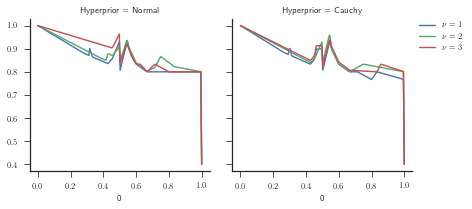

In [21]:
g = sns.FacetGrid(data=interpolated_pr_scores, col='Hyperprior', hue='Nu', col_order=['Normal', 'Cauchy'], )
def draw_average_pr(x, *args, **kwargs):
    sns.plt.plot(np.linspace(0, 1, num=200, endpoint=True), x.values[0], **kwargs)
g.map(draw_average_pr, 0)


handles, labels = g.axes[0,0].get_legend_handles_labels()
labels = ['$\\nu = {}$'.format(nu) for nu in labels]
l = sns.plt.legend(handles, labels, bbox_to_anchor=(1.02, 1), loc=2, borderaxespad=0)
#sns.plt.tight_layout()
#sns.plt.savefig('/Users/maexlich/Google Drive/Studium/Master/4. Masterthesis/3. Thesis/Figures/Results/Hyperparameter-selection/PR-hyperprior-nu.pdf', bbox_extra_artists=(l,), bbox_inches='tight')

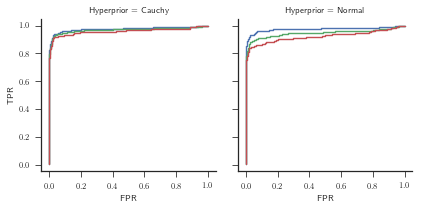

In [22]:
from sklearn.metrics import roc_curve, roc_auc_score
def compute_pr_curve(data):
    predicted = data['Prediction (std)']
    gt = data['GT True']
    fpr, tpr, _ = roc_curve(gt, predicted)
    auc = roc_auc_score(gt, predicted)
    return pd.Series({'FPR':fpr, 'TPR':tpr, 'AUC': auc})

pr_scores = pip_values.groupby(['Hyperprior', 'Nu']).apply(compute_pr_curve).reset_index()
g = sns.FacetGrid(data=pr_scores, col='Hyperprior', hue='Nu')
def draw_test(x, y, *args, **kwargs):
    sns.plt.plot(x.values[0], y.values[0], **kwargs)
g.map(draw_test, 'FPR', 'TPR')

In [23]:
ax = g.axes[0, 0]
ax.axhline(0.5)

/Users/maexlich/.miniconda/envs/bayesian_microbiome/lib/python3.6/site-packages/ipykernel_launcher.py:8: SettingWithCopyWarning: 
A value is trying to be set on a copy of a slice from a DataFrame.
Try using .loc[row_indexer,col_indexer] = value instead

See the caveats in the documentation: http://pandas.pydata.org/pandas-docs/stable/indexing.html#indexing-view-versus-copy
  
/Users/maexlich/.miniconda/envs/bayesian_microbiome/lib/python3.6/site-packages/ipykernel_launcher.py:9: SettingWithCopyWarning: 
A value is trying to be set on a copy of a slice from a DataFrame.
Try using .loc[row_indexer,col_indexer] = value instead

See the caveats in the documentation: http://pandas.pydata.org/pandas-docs/stable/indexing.html#indexing-view-versus-copy
  if __name__ == '__main__':


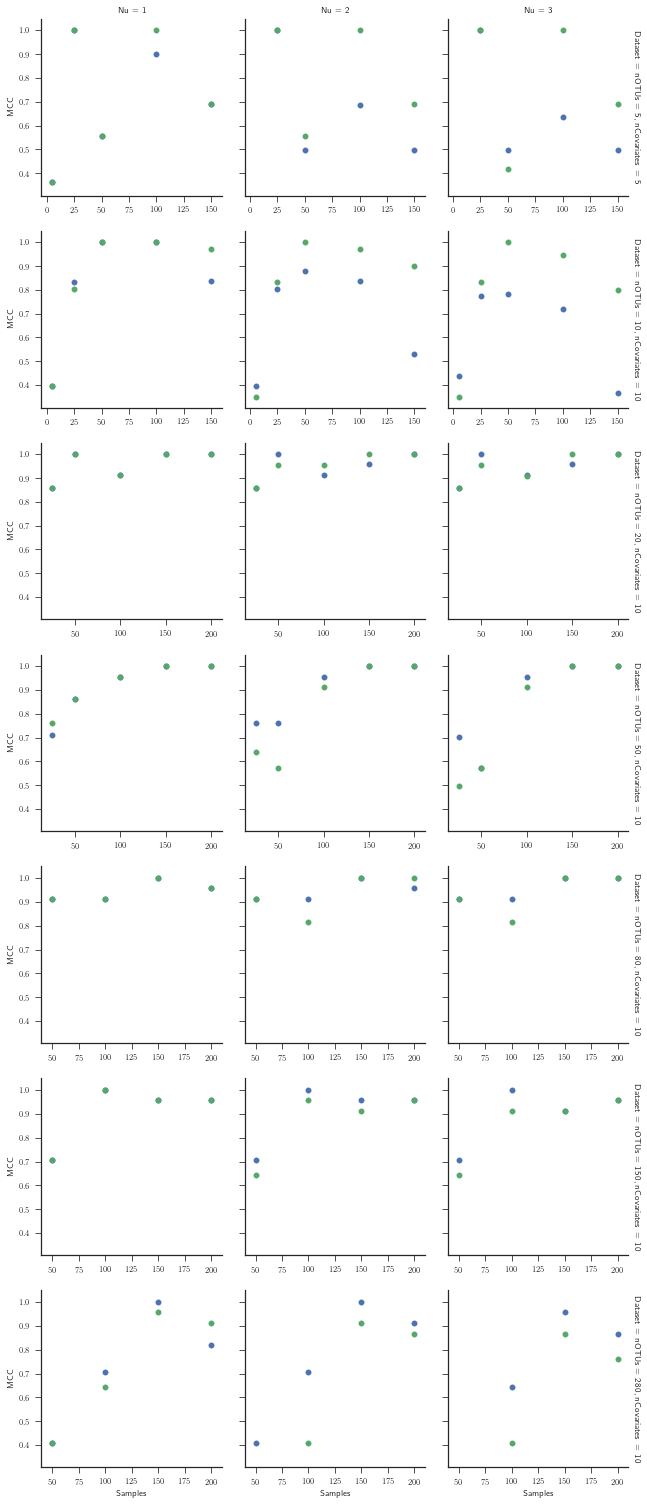

In [24]:
def get_hyperprior_nu_label(row):
    return row['Type'] if row['Type'] == 'no sparcity' else '{}, $\\nu = {}$'.format(row['Hyperprior'], row['Nu'])

def get_dataset_without_samples(row):
    #print(row['OTUs'], row['Covariates'])
    return 'nOTUs = {}, nCovariates = {}'.format(row['OTUs'], row['Covariates'])

only_noncentered['Model'] = only_noncentered.apply(get_hyperprior_nu_label, axis=1)
only_noncentered['Dataset'] = only_noncentered.apply(get_dataset_without_samples, axis=1)
g = sns.FacetGrid(data=only_noncentered, row='Dataset', hue='Hyperprior', col='Nu', margin_titles=True, sharex='row')
g.map(sns.plt.scatter, 'Samples', 'MCC')

In [25]:
beta_statistics.apply(get_dataset_without_samples, axis=1)

1          nOTUs = 5, nCovariates = 5
3          nOTUs = 5, nCovariates = 5
8          nOTUs = 5, nCovariates = 5
13         nOTUs = 5, nCovariates = 5
18         nOTUs = 5, nCovariates = 5
23         nOTUs = 5, nCovariates = 5
28         nOTUs = 5, nCovariates = 5
33         nOTUs = 5, nCovariates = 5
38         nOTUs = 5, nCovariates = 5
43         nOTUs = 5, nCovariates = 5
48         nOTUs = 5, nCovariates = 5
53         nOTUs = 5, nCovariates = 5
58         nOTUs = 5, nCovariates = 5
63         nOTUs = 5, nCovariates = 5
65         nOTUs = 5, nCovariates = 5
70         nOTUs = 5, nCovariates = 5
75         nOTUs = 5, nCovariates = 5
80         nOTUs = 5, nCovariates = 5
85         nOTUs = 5, nCovariates = 5
90         nOTUs = 5, nCovariates = 5
95         nOTUs = 5, nCovariates = 5
100        nOTUs = 5, nCovariates = 5
105        nOTUs = 5, nCovariates = 5
110        nOTUs = 5, nCovariates = 5
115        nOTUs = 5, nCovariates = 5
120        nOTUs = 5, nCovariates = 5
125        n

In [26]:
only_noncentered['Dataset'].unique()

array(['nOTUs = 5, nCovariates = 5', 'nOTUs = 10, nCovariates = 10',
       'nOTUs = 20, nCovariates = 10', 'nOTUs = 50, nCovariates = 10',
       'nOTUs = 80, nCovariates = 10', 'nOTUs = 150, nCovariates = 10',
       'nOTUs = 280, nCovariates = 10'], dtype=object)

In [27]:
len(fitting_statistics.Model.unique()), len(fitting_statistics.Dataset.unique())

AttributeError: 'DataFrame' object has no attribute 'Model'

In [ ]:
filtered = beta_statistics[beta_statistics.Model != 'no sparcity']
g = sns.FacetGrid(data=filtered, col='Nu', row='Dataset', hue='Hyperprior', sharey='row', margin_titles=True)
#def test(*args, **kwargs):
#    print(args)

g.map(sns.plt.scatter, 'Samples', 'MSE')